## Import Necessary Libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import os
import numpy as np
import matplotlib.pyplot as plt


## Check For GPU

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


## EgdePtychoNN Model

In [3]:
class ReconSmallPhaseModel(nn.Module):
    def __init__(self, nconv: int = 16):
        super(ReconSmallPhaseModel, self).__init__()
        self.nconv = nconv
        self.encoder = nn.Sequential( # Appears sequential has similar functionality as TF avoiding need for separate model definition and activ
            *self.down_block(1, self.nconv),
            *self.down_block(self.nconv, self.nconv * 2),
            *self.down_block(self.nconv * 2, self.nconv * 4),
            *self.down_block(self.nconv * 4, self.nconv * 8), 
            *self.down_block(self.nconv * 8, self.nconv * 16), 
            *self.down_block(self.nconv * 16, self.nconv * 32),
            #*self.down_block(self.nconv * 32, self.nconv * 32)   # Commented out to make outputs match labels (128,128) instead of (64,64)
        )
        
        # amplitude model
        #self.decoder1 = nn.Sequential(
            #*self.up_block(self.nconv * 32, self.nconv * 32),
         #   *self.up_block(self.nconv * 32, self.nconv * 16),
          #  *self.up_block(self.nconv * 16, self.nconv * 8),
           # *self.up_block(self.nconv * 8, self.nconv * 8),
            #*self.up_block(self.nconv * 8, self.nconv * 4),
            #*self.up_block(self.nconv * 4, self.nconv * 2),
            #*self.up_block(self.nconv * 2, self.nconv * 1),
            #nn.Conv2d(self.nconv * 1, 1, 3, stride=1, padding=(1,1)),
        #)
        
        # phase model
        self.decoder2 = nn.Sequential(
            #*self.up_block(self.nconv * 32, self.nconv * 32),
            *self.up_block(self.nconv * 32, self.nconv * 16),
            *self.up_block(self.nconv * 16, self.nconv * 8),
            *self.up_block(self.nconv * 8, self.nconv * 8),
            *self.up_block(self.nconv * 8, self.nconv * 4),
            *self.up_block(self.nconv * 4, self.nconv * 2),
            *self.up_block(self.nconv * 2, self.nconv * 1),
            nn.Conv2d(self.nconv * 1, 1, 3, stride=1, padding=(1,1)),
            nn.Tanh()
        )
    def down_block(self, filters_in, filters_out):
        block = [
            nn.Conv2d(in_channels=filters_in, out_channels=filters_out, kernel_size=3, stride=1, padding=(1,1)),
            nn.ReLU(),
            nn.Conv2d(filters_out, filters_out, 3, stride=1, padding=(1,1)),
            nn.ReLU(),
            nn.MaxPool2d((2,2))
        ]
        return block
    
    
    def up_block(self, filters_in, filters_out):
        block = [
            nn.Conv2d(filters_in, filters_out, 3, stride=1, padding=(1,1)),
            nn.ReLU(),
            nn.Conv2d(filters_out, filters_out, 3, stride=1, padding=(1,1)),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear')
        ]
        return block
        
    
    def forward(self, x):
        with torch.cuda.amp.autocast():
            #print("Input size:", x.size())  # Print input size
            x1 = self.encoder(x)
            #print("After encoder:", x1.size())  # Print size after encoder
            
            # amp = self.decoder1(x1)  # If you want to test decoder1 as well
            ph = self.decoder2(x1)
            #print("After decoder2:", ph.size())  # Print size after decoder2
            
            # Restore -pi to pi range
            ph = ph * np.pi  # Using tanh activation (-1 to 1) for phase, so multiply by pi
            #print("Final output size:", ph.size())  # Print final output size

        return ph

## Get Data From Scan Files

In [4]:
class PtychographyDataset(Dataset):
    def __init__(self, npz_files):

        # Initialize empty lists for inputs and labels from all files
        all_inputs = []
        all_labels = []

        # Loop through all 10 files
        for npz_file in npz_files:
            data = np.load(npz_file)
            inputs = torch.tensor(data["reciprocal"], dtype=torch.float32)
            labels = np.angle(data["real"])
            labels = torch.tensor(labels, dtype=torch.float32)

            # Ensure input and label shapes are correct 
            if len(inputs.shape) == 3:  
                inputs = inputs.unsqueeze(1)  # Add channel dim (C=1)
                labels = labels.unsqueeze(1)  # Add channel dim (C=1)

            # Append the data from file to lists
            all_inputs.append(inputs)
            all_labels.append(labels)

        # Concatenate all data 
        self.inputs = torch.cat(all_inputs, dim = 0)
        self.labels = torch.cat(all_labels, dim = 0)


    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.labels[idx]

## Initialize The Model

In [5]:
# List of file paths
npz_files = [
    "/home/sfowler/Downloads/NewScans/scan674.npz", "/home/sfowler/Downloads/NewScans/scan683.npz", "/home/sfowler/Downloads/NewScans/scan692.npz", 
    "/home/sfowler/Downloads/NewScans/scan701.npz", "/home/sfowler/Downloads/NewScans/scan710.npz", "/home/sfowler/Downloads/NewScans/scan720.npz", 
    "/home/sfowler/Downloads/NewScans/scan730.npz", "/home/sfowler/Downloads/NewScans/scan740.npz", "/home/sfowler/Downloads/NewScans/scan750.npz", 
    "/home/sfowler/Downloads/NewScans/scan760.npz", "/home/sfowler/Downloads/NewScans/scan770.npz"
]

# Load dataset
train_dataset = PtychographyDataset(npz_files)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Initialize model
model = ReconSmallPhaseModel()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-5) # First Optimizer I tried
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 10, gamma = 0.1)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum = 0.9) # Caused Convergance 
#optimizer = torch.optim.RMSprop(model.parameters(), lr=1e-4)
#optimizer = torch.optim.Adagrad(model.parameters(), lr=0.1)
#scalar = torch.GradScaler()
#criterion = nn.MSELoss()  #First Loss I tried
criterion = nn.L1Loss() # Second Loss I tried
#criterion = nn.SmoothL1Loss() # Changed Loss 

## Training Function

In [6]:
def train(model, train_loader, criterion, optimizer, start_epoch, num_epochs, device):
#def train(model, train_loader, criterion, optimizer, scheduler, start_epoch, num_epochs, device):
    model.train()  # Set model to training mode
    for epoch in range(start_epoch, start_epoch + num_epochs):
        running_loss = 0.0  # Track total loss for the epoch
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move to GPU if available

            optimizer.zero_grad()  # Reset gradients
            outputs = model(inputs)  # Forward pass

            loss = criterion(outputs, labels)  # Compute loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update model parameters

            running_loss += loss.item()  # Accumulate loss

        #scheduler.step()
        avg_loss = running_loss / len(train_loader)  # Compute average loss per batch
        print(f"Epoch [{epoch+1}/{start_epoch + num_epochs}], Ave Loss: {avg_loss:.5f}, Loss: {loss.item():.5f}, Learning Rate: {optimizer.param_groups[0]['lr']}")

        final_loss = loss # Update final loss to the current epochs average loss

    print("Training complete.")
    return final_loss

## Save Model State

In [7]:
def save_state(model, optimizer, epoch, loss, filename="checkpoint.pth"):
#def save_state(model, optimizer, scheduler, epoch, loss, filename="checkpoint.pth"):
    state = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        #'scheduler_state_dict': scheduler.state_dict(),
        'loss': loss
    }
    torch.save(state, filename)
    print(f"Checkpoint saved at epoch {epoch}")

## Load Model State

In [8]:
def load_state(model, optimizer, filename="checkpoint.pth"):
#def load_state(model, optimizer, scheduler, filename="checkpoint.pth"):
    state = torch.load(filename)
    
    model.load_state_dict(state['model_state_dict'])
    optimizer.load_state_dict(state['optimizer_state_dict'])
    #scheduler.load_state_dict(state['scheduler_state_dict'])
    
    start_epoch = state['epoch'] + 1  # Resume from the next epoch
    loss = state['loss']
    
    print(f"Checkpoint loaded. Resuming from epoch {start_epoch}")
    #return model, optimizer, scheduler, start_epoch, loss
    return model, optimizer, start_epoch, loss


## Train Model

In [18]:
checkpoint_path = "checkpoint.pth"

# If there's a checkpoint, load it.
if os.path.exists(checkpoint_path):
    model, optimizer, start_epoch, last_loss = load_state(model, optimizer, checkpoint_path)
    print(f"Resuming training from epoch {start_epoch}")
else:
    start_epoch = 0
    print(f"Starting fresh training from epoch {start_epoch}")

# Define the total number of epochs you want to train in this run.
num_epochs = 40

final_loss = train(model, train_loader, criterion, optimizer, start_epoch, num_epochs, device)

final_epoch = start_epoch + num_epochs - 1  # last epoch trained in this run

save_state(model, optimizer, final_epoch, final_loss, filename=checkpoint_path)

/tmp/ipykernel_155280/2724372533.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(filename)
/tmp/ipykernel_155280/2692532804.py:62: FutureWarning: `tor

Checkpoint loaded. Resuming from epoch 260
Resuming training from epoch 260
Epoch [261/300], Ave Loss: 0.14950, Loss: 0.14588, Learning Rate: 3e-05
Epoch [262/300], Ave Loss: 0.14865, Loss: 0.16279, Learning Rate: 3e-05
Epoch [263/300], Ave Loss: 0.14841, Loss: 0.14248, Learning Rate: 3e-05
Epoch [264/300], Ave Loss: 0.14977, Loss: 0.20341, Learning Rate: 3e-05
Epoch [265/300], Ave Loss: 0.15070, Loss: 0.15452, Learning Rate: 3e-05
Epoch [266/300], Ave Loss: 0.14801, Loss: 0.14352, Learning Rate: 3e-05
Epoch [267/300], Ave Loss: 0.14910, Loss: 0.19861, Learning Rate: 3e-05
Epoch [268/300], Ave Loss: 0.14940, Loss: 0.17457, Learning Rate: 3e-05
Epoch [269/300], Ave Loss: 0.14732, Loss: 0.13955, Learning Rate: 3e-05
Epoch [270/300], Ave Loss: 0.14622, Loss: 0.13687, Learning Rate: 3e-05
Epoch [271/300], Ave Loss: 0.14527, Loss: 0.11703, Learning Rate: 3e-05
Epoch [272/300], Ave Loss: 0.14721, Loss: 0.13037, Learning Rate: 3e-05
Epoch [273/300], Ave Loss: 0.14528, Loss: 0.11758, Learning 

In [19]:
for inputs, labels in train_loader:
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = model(inputs)
    print("Outputs Min:", outputs.min().item(), "Max:", outputs.max().item(), "Mean:", outputs.mean().item())
    break

Outputs Min: -2.284044027328491 Max: 1.4645435810089111 Mean: -0.021261930465698242


/tmp/ipykernel_155280/2692532804.py:62: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


## Visualize Output

Output Stats - Min: -2.273747444152832 Max: 1.390967607498169 Mean: 0.003022238612174988


/tmp/ipykernel_155280/2692532804.py:62: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


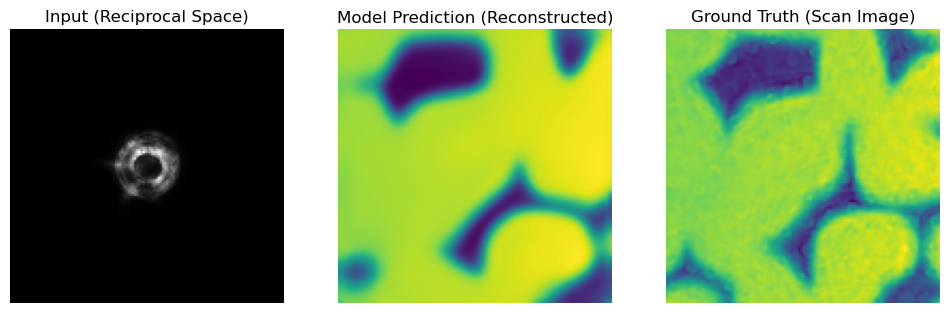

Output Stats - Min: -2.273747444152832 Max: 1.390967607498169 Mean: 0.003022238612174988


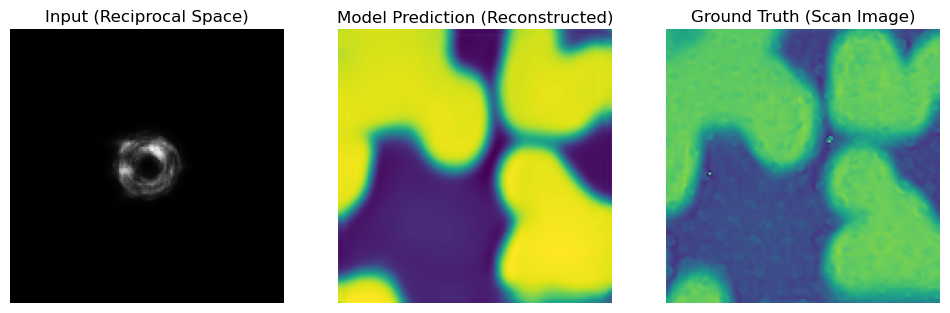

Output Stats - Min: -2.273747444152832 Max: 1.390967607498169 Mean: 0.003022238612174988


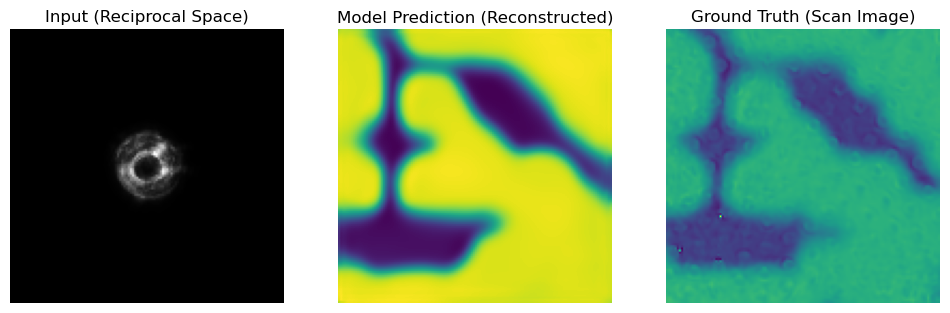

In [20]:
def normalize_image(image):
    min_val, max_val = image.min(), image.max()
    return (image - min_val) / (max_val - min_val) if max_val > min_val else image

def visualize_prediction(model, dataloader, num_samples=1):
    model.eval()
    
    with torch.no_grad():
        for inputs, labels in dataloader:  # Get a batch
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)  # Model's predicted image
            break  # Only take the first batch

    for i in range(num_samples):  # Loop through first few samples
        print("Output Stats - Min:", outputs.min().item(), "Max:", outputs.max().item(), "Mean:", outputs.mean().item())

        plt.figure(figsize=(12, 4))

        # Original scan (Ground Truth)
        plt.subplot(1, 3, 1)
        plt.imshow(inputs[i, 0].cpu().numpy(), cmap="gray")
        plt.title("Input (Reciprocal Space)")
        plt.axis("off")

        # Model Prediction
        plt.subplot(1, 3, 2)
        plt.imshow(outputs[i, 0].cpu().numpy(), cmap="viridis")
        plt.title("Model Prediction (Reconstructed)")
        plt.axis("off")

        # Ground Truth
        plt.subplot(1, 3, 3)
        plt.imshow(labels[i, 0].cpu().numpy(), cmap="viridis")
        plt.title("Ground Truth (Scan Image)")
        plt.axis("off")

        plt.show()

# Run visualization
visualize_prediction(model, train_loader, num_samples=3)